In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/in-class-kaggle-predict-cirrhosis-outcomes'

files = os.listdir(data_path)
print(files)


['train.csv', 'test.csv', 'sample_submission.csv']


In [ ]:
train_path = '/content/drive/MyDrive/in-class-kaggle-predict-cirrhosis-outcomes/train.csv'
test_path = '/content/drive/MyDrive/in-class-kaggle-predict-cirrhosis-outcomes/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(train_df)


Observations: 7905
Variables: 20
cat_cols: 8
num_cols: 12
cat_but_car: 0
num_but_cat: 1


Numerik Değişkenler: ['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
Kategorik Değişkenler: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status', 'Stage']


Top 20 Feature:
          Feature     Score
5       Bilirubin  0.500080
17    Prothrombin  0.397293
7          Copper  0.388777
15         N_Days  0.303452
18           SGOT  0.243095
1         Albumin  0.213135
0             Age  0.099039
24  Tryglicerides  0.089813
6     Cholesterol  0.082371
16      Platelets  0.071615
2        Alk_Phos  0.054305


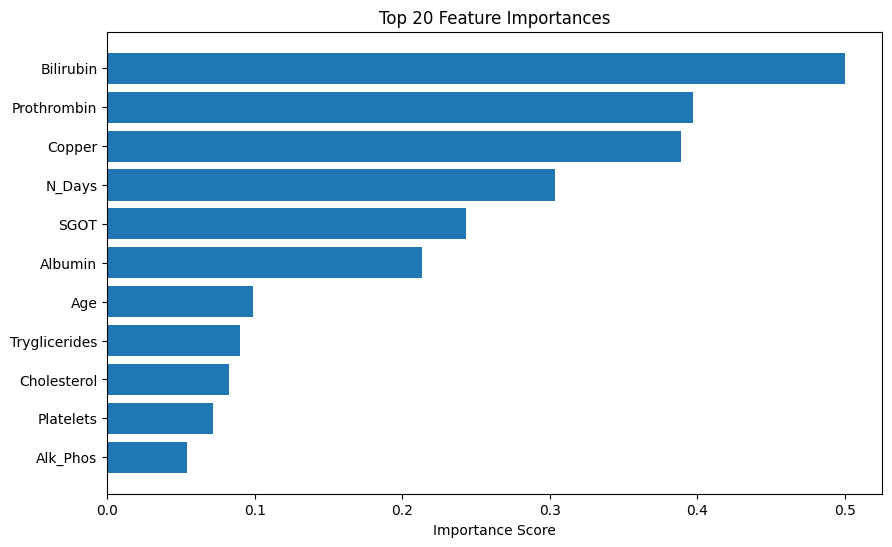

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder

def automatic_feature_importance(train_df, target_col, cat_cols, num_cols, task_type="classification", top_n=20, feature_threshold=0.01):
    """
    train_df: pd.DataFrame
        Eğitim veri seti.
    target_col: str
        Hedef değişkenin ismi.
    cat_cols: list
        Kategorik değişkenlerin listesi.
    num_cols: list
        Numerik değişkenlerin listesi.
    task_type: str
        'classification' ya da 'regression' (problem tipi)
    top_n: int
        Kaç tane en önemli feature görmek istiyorsun.
    feature_threshold: float
        Önem skoru eşik değeri, altındaki feature'lar atılır.
    """

    X = train_df.drop(columns=[target_col])
    y = train_df[target_col]

    print(f"Numerik Değişkenler: {num_cols}")
    print(f"Kategorik Değişkenler: {cat_cols}\n")

    feature_scores = []

    # 1. Numerik Değişkenler: ANOVA F-Score
    try:
        X_num = X[num_cols].fillna(0)
        F, p = f_classif(X_num, y)
        for idx, col in enumerate(num_cols):
            feature_scores.append((col, F[idx], "ANOVA"))
    except Exception as e:
        print(f"ANOVA hesaplanamadı: {e}")

    # 2. Kategorik Değişkenler: Chi-Square Testi
    for col in cat_cols:
        if col == target_col:
            continue  # hedef değişkenle kendi arasında test yapma
        try:
            table = pd.crosstab(X[col], y)
            chi2, p, dof, ex = chi2_contingency(table)
            importance = 1 - p
            feature_scores.append((col, importance, "Chi-Square"))
        except Exception as e:
            print(f"Chi-Square hesaplanamadı: {col}")

    # 3. One-Hot Encoding + Random Forest Feature Importance
    feature_cols = [col for col in (cat_cols + num_cols) if col != target_col]
    X_encoded = pd.get_dummies(X[feature_cols], drop_first=True).fillna(0)

    if task_type == "classification":
        model = RandomForestClassifier(random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)

    model.fit(X_encoded, y)

    rf_importances = model.feature_importances_

    for idx, col in enumerate(X_encoded.columns):
        feature_scores.append((col, rf_importances[idx], "RandomForest"))

    # Hepsini DataFrame'e çevir
    feature_importance_df = pd.DataFrame(feature_scores, columns=["Feature", "Score", "Method"])

    # Skoru normalize et (0-1 arası yap)
    feature_importance_df["Score"] = (feature_importance_df["Score"] - feature_importance_df["Score"].min()) / (feature_importance_df["Score"].max() - feature_importance_df["Score"].min())

    # Aynı feature birkaç farklı yöntemle ölçüldüyse ortalama al
    final_scores = feature_importance_df.groupby("Feature")["Score"].mean().reset_index()

    # Eşik değerinin altında kalan feature'ları at
    final_scores = final_scores[final_scores["Score"] >= feature_threshold]

    final_scores = final_scores.sort_values(by="Score", ascending=False)

    print(f"\nTop {top_n} Feature:")
    print(final_scores.head(top_n))

    # Grafik Çizimi
    plt.figure(figsize=(10, 6))
    plt.barh(final_scores.head(top_n)["Feature"], final_scores.head(top_n)["Score"])
    plt.xlabel("Importance Score")
    plt.title(f"Top {top_n} Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()


    # Önemli Feature'ları Seç
    selected_features = [col for col in final_scores["Feature"] if col in train_df.columns]
    reduced_df = train_df[selected_features + [target_col]]

    return final_scores, reduced_df


importance_df, reduced_df = automatic_feature_importance(
    train_df,
    target_col="Status",
    cat_cols=cat_cols,
    num_cols=num_cols,
    task_type="classification",
    top_n=20,
    feature_threshold=0.01
)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency, f_oneway
from itertools import combinations

def analyze_feature_relations(data, selected_features, cat_cols, num_cols, visualize=True):
    """
    Seçilen önemli feature'lar arasında ilişki analizi yapar.

    data: pd.DataFrame
        Çalışılacak veri seti.
    selected_features: list
        İncelenecek feature listesi.
    cat_cols: list
        Kategorik değişkenler listesi.
    num_cols: list
        Numerik değişkenler listesi.
    visualize: bool
        True ise grafik çizer.

    Return:
    pd.DataFrame - İlişki analizi sonuçları.
    """
    results = []

    feature_pairs = list(combinations(selected_features, 2))

    for feat1, feat2 in feature_pairs:
        if feat1 in num_cols and feat2 in num_cols:
            # Numerik x Numerik --> Pearson Korelasyonu
            try:
                corr, pval = pearsonr(data[feat1].dropna(), data[feat2].dropna())
                results.append({"Feature1": feat1, "Feature2": feat2, "Relation": "Pearson", "Score": corr, "p-value": pval})

                if visualize:
                    plt.figure(figsize=(6,4))
                    sns.scatterplot(x=feat1, y=feat2, data=data)
                    plt.title(f"Scatterplot: {feat1} vs {feat2}")
                    plt.show()

            except Exception as e:
                print(f"Pearson hesaplanamadı: {feat1}, {feat2}")

        elif feat1 in cat_cols and feat2 in cat_cols:
            # Kategorik x Kategorik --> Chi-Square Testi
            try:
                table = pd.crosstab(data[feat1], data[feat2])
                chi2, p, dof, ex = chi2_contingency(table)
                results.append({"Feature1": feat1, "Feature2": feat2, "Relation": "Chi-Square", "Score": chi2, "p-value": p})

                if visualize:
                    plt.figure(figsize=(6,5))
                    sns.heatmap(table, annot=True, fmt="d")
                    plt.title(f"Heatmap: {feat1} vs {feat2}")
                    plt.show()

            except Exception as e:
                print(f"Chi-Square hesaplanamadı: {feat1}, {feat2}")

        else:
            # Biri kategorik, biri numerik --> ANOVA Testi
            try:
                cat_feat = feat1 if feat1 in cat_cols else feat2
                num_feat = feat2 if feat1 in cat_cols else feat1

                groups = [group[num_feat].dropna().values for name, group in data.groupby(cat_feat)]
                f_stat, p_val = f_oneway(*groups)
                results.append({"Feature1": cat_feat, "Feature2": num_feat, "Relation": "ANOVA", "Score": f_stat, "p-value": p_val})

                if visualize:
                    plt.figure(figsize=(6,4))
                    sns.boxplot(x=cat_feat, y=num_feat, data=data)
                    plt.title(f"Boxplot: {num_feat} by {cat_feat}")
                    plt.show()

            except Exception as e:
                print(f"ANOVA hesaplanamadı: {feat1}, {feat2}")

    result_df = pd.DataFrame(results)
    return result_df

selected_features = importance_df["Feature"].tolist()

relation_results = analyze_feature_relations(
    data=train_df,
    selected_features=selected_features,
    cat_cols=cat_cols,
    num_cols=num_cols,
    visualize=False
)



In [ ]:
relation_results

,Feature1,Feature2,Relation,Score,p-value
0,Bilirubin,Prothrombin,Pearson,0.294325,9.645766e-158
1,Bilirubin,Copper,Pearson,0.442223,0.000000e+00
2,Bilirubin,N_Days,Pearson,-0.346434,1.009765e-221
3,Bilirubin,SGOT,Pearson,0.368653,5.119362e-253
4,Bilirubin,Albumin,Pearson,-0.303191,9.751116e-168
5,Bilirubin,Age,Pearson,0.099016,1.106373e-18
6,Bilirubin,Tryglicerides,Pearson,0.315681,1.999586e-182
7,Bilirubin,Cholesterol,Pearson,0.302153,1.503880e-166
8,Bilirubin,Platelets,Pearson,-0.081987,2.865105e-13
9,Bilirubin,Alk_Phos,Pearson,0.131317,9.557373e-32


In [ ]:
# 1. Anlamlı ilişkileri seçelim
significant_relations = relation_results[relation_results["p-value"] < 0.05]

# 2. Skor değerine göre büyükten küçüğe sıralayalım
significant_relations = significant_relations.sort_values(by="Score", ascending=False)

# 3. Sonuçlara bakalım
print(significant_relations)


         Feature1       Feature2 Relation     Score        p-value
1       Bilirubin         Copper  Pearson  0.442223   0.000000e+00
3       Bilirubin           SGOT  Pearson  0.368653  5.119362e-253
37           SGOT    Cholesterol  Pearson  0.326864  3.426629e-196
20         Copper           SGOT  Pearson  0.323226  1.196021e-191
6       Bilirubin  Tryglicerides  Pearson  0.315681  1.999586e-182
7       Bilirubin    Cholesterol  Pearson  0.302153  1.503880e-166
0       Bilirubin    Prothrombin  Pearson  0.294325  9.645766e-158
23         Copper  Tryglicerides  Pearson  0.290435  1.816059e-153
49  Tryglicerides    Cholesterol  Pearson  0.274044  3.446936e-136
28         N_Days        Albumin  Pearson  0.255724  3.031841e-118
10    Prothrombin         Copper  Pearson  0.238771  6.852817e-103
24         Copper    Cholesterol  Pearson  0.168266   2.722343e-51
36           SGOT  Tryglicerides  Pearson  0.155287   7.418604e-44
32         N_Days      Platelets  Pearson  0.147626   9.285535

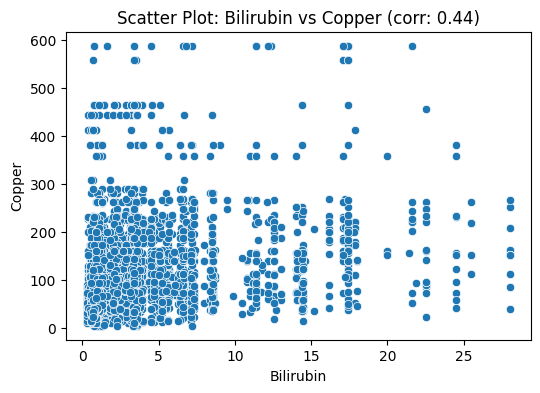

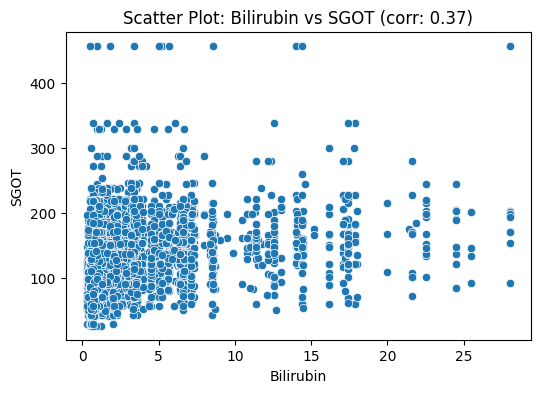

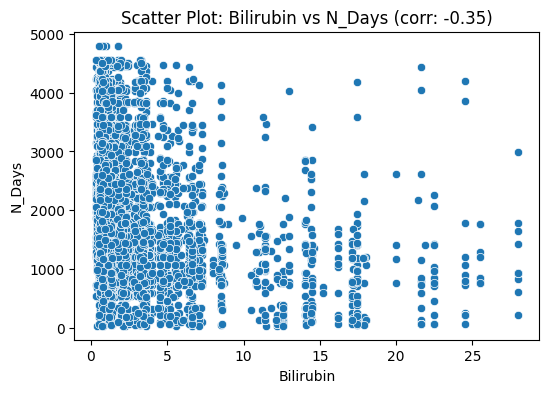

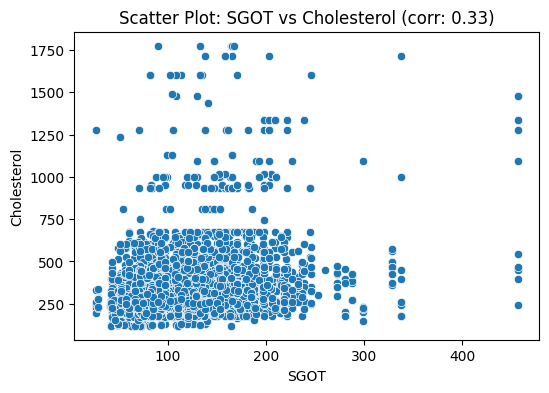

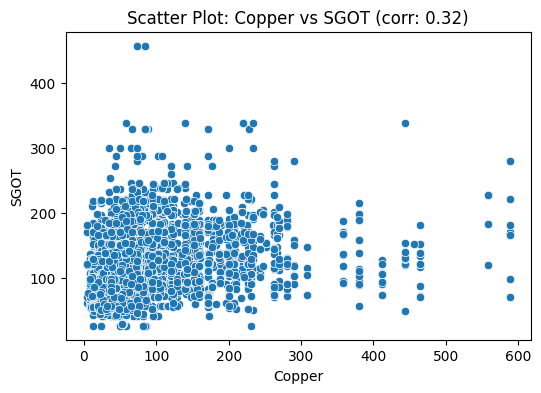

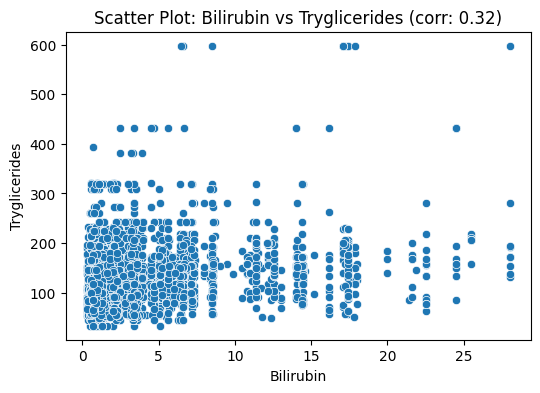

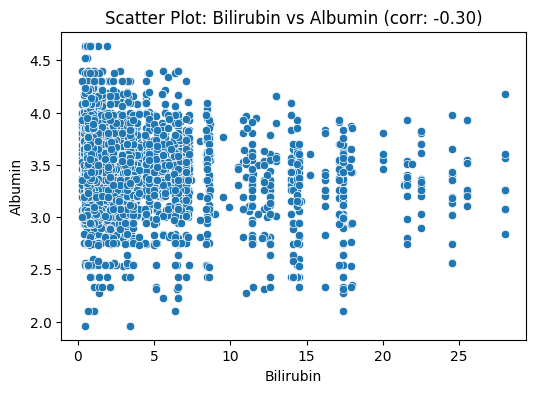

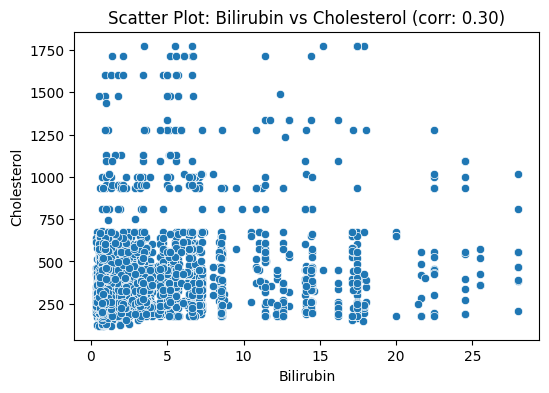

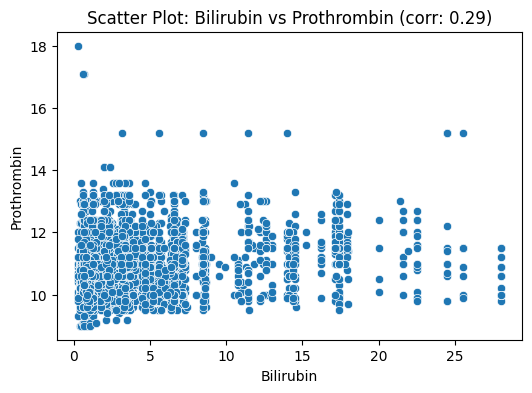

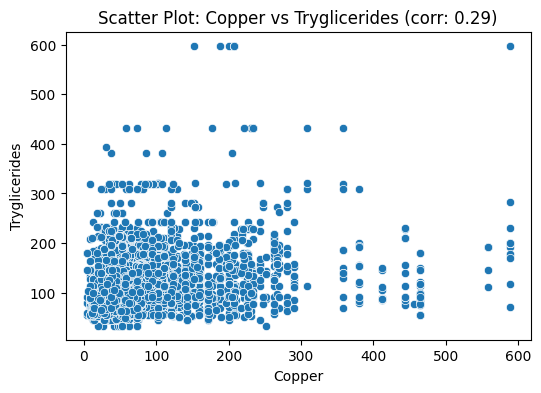

In [ ]:
top10 = relation_results.sort_values(by="Score", key=abs, ascending=False).head(10)

for index, row in top10.iterrows():
    feat1 = row["Feature1"]
    feat2 = row["Feature2"]
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=feat1, y=feat2, data=train_df)
    plt.title(f"Scatter Plot: {feat1} vs {feat2} (corr: {row['Score']:.2f})")
    plt.show()


In [ ]:
def create_features_from_relations(df, relation_df, threshold=0.3):
    new_features = pd.DataFrame(index=df.index)

    # Skor mutlak değeri threshold'tan büyük olanları seçelim
    strong_relations = relation_df[relation_df["Score"].abs() > threshold]

    for index, row in strong_relations.iterrows():
        feat1 = row["Feature1"]
        feat2 = row["Feature2"]

        # Fark
        new_features[f"{feat1}_minus_{feat2}"] = df[feat1] - df[feat2]

        # Oran
        new_features[f"{feat1}_div_{feat2}"] = df[feat1] / (df[feat2] + 1e-5)

        # Çarpım
        new_features[f"{feat1}_times_{feat2}"] = df[feat1] * df[feat2]

    return new_features

new_derived_features = create_features_from_relations(train_df, relation_results, threshold=0.3)
train_extend = pd.concat([train_df, new_derived_features], axis=1)



In [ ]:
train_extend

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Bilirubin_times_Tryglicerides,Bilirubin_minus_Cholesterol,Bilirubin_div_Cholesterol,Bilirubin_times_Cholesterol,Copper_minus_SGOT,Copper_div_SGOT,Copper_times_SGOT,SGOT_minus_Cholesterol,SGOT_div_Cholesterol,SGOT_times_Cholesterol
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,...,144.9,-313.7,0.007278,726.8,-7.80,0.956618,30925.60,-136.20,0.568987,56816.80
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,...,79.2,-363.1,0.002473,327.6,-71.85,0.467186,8495.55,-229.15,0.370467,49085.40
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,...,165.0,-295.7,0.011037,986.7,11.65,1.097612,15634.85,-179.65,0.399164,35685.65
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,...,57.6,-255.4,0.002344,153.6,-13.30,0.813464,4135.40,-184.70,0.278516,18252.80
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,...,105.6,-344.9,0.003179,380.6,-62.55,0.501792,7909.65,-220.45,0.362861,43440.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,...,179.2,-308.2,0.002589,247.2,-41.05,0.480708,3003.90,-229.95,0.255825,24426.45
7901,7901,1492,Placebo,17031,F,N,Y,N,N,0.9,...,70.2,-259.1,0.003462,234.0,-80.00,0.436620,8804.00,-118.00,0.546154,36920.00
7902,7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,...,124.0,-223.0,0.008889,450.0,-18.75,0.731183,3557.25,-155.25,0.310000,15693.75
7903,7903,3584,D-penicillamine,22960,M,N,Y,N,N,0.7,...,82.6,-247.3,0.002823,173.6,-25.35,0.557977,1835.20,-190.65,0.231250,14222.80


Observations: 7905
Variables: 44
cat_cols: 8
num_cols: 36
cat_but_car: 0
num_but_cat: 1
Numerik Değişkenler: ['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Bilirubin_minus_Copper', 'Bilirubin_div_Copper', 'Bilirubin_times_Copper', 'Bilirubin_minus_N_Days', 'Bilirubin_div_N_Days', 'Bilirubin_times_N_Days', 'Bilirubin_minus_SGOT', 'Bilirubin_div_SGOT', 'Bilirubin_times_SGOT', 'Bilirubin_minus_Albumin', 'Bilirubin_div_Albumin', 'Bilirubin_times_Albumin', 'Bilirubin_minus_Tryglicerides', 'Bilirubin_div_Tryglicerides', 'Bilirubin_times_Tryglicerides', 'Bilirubin_minus_Cholesterol', 'Bilirubin_div_Cholesterol', 'Bilirubin_times_Cholesterol', 'Copper_minus_SGOT', 'Copper_div_SGOT', 'Copper_times_SGOT', 'SGOT_minus_Cholesterol', 'SGOT_div_Cholesterol', 'SGOT_times_Cholesterol']
Kategorik Değişkenler: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status', 'Stage']


Top 30 Feature:
    

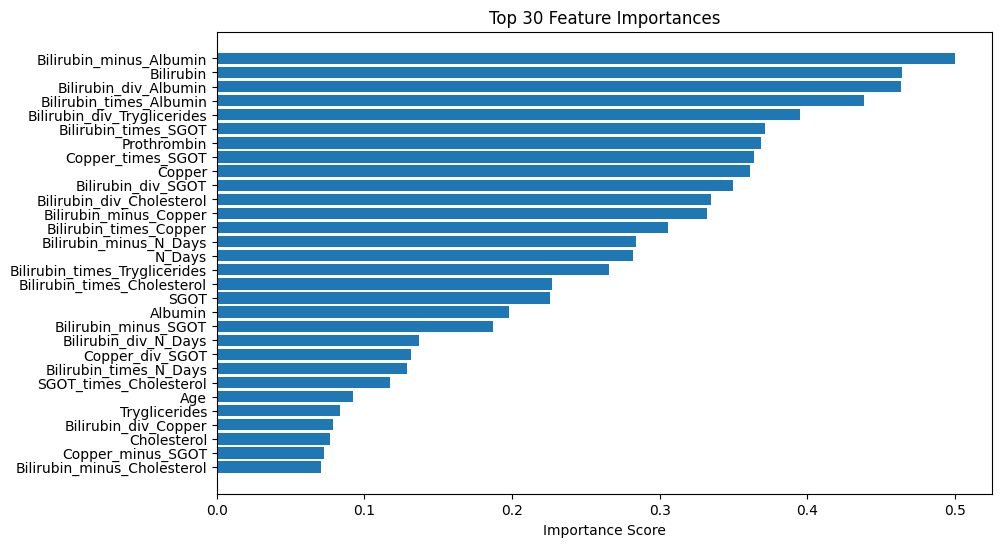

In [ ]:
cat_cols_ext, num_cols_ext, _ = grab_col_names(train_extend)

# 3. Şimdi doğru şekilde feature importance hesaplayalım
importance_df_new, reduced_df_new = automatic_feature_importance(
    train_extend,
    target_col="Status",
    cat_cols=cat_cols_ext,
    num_cols=num_cols_ext,
    task_type="classification",
    top_n=30,
    feature_threshold=0.01
)

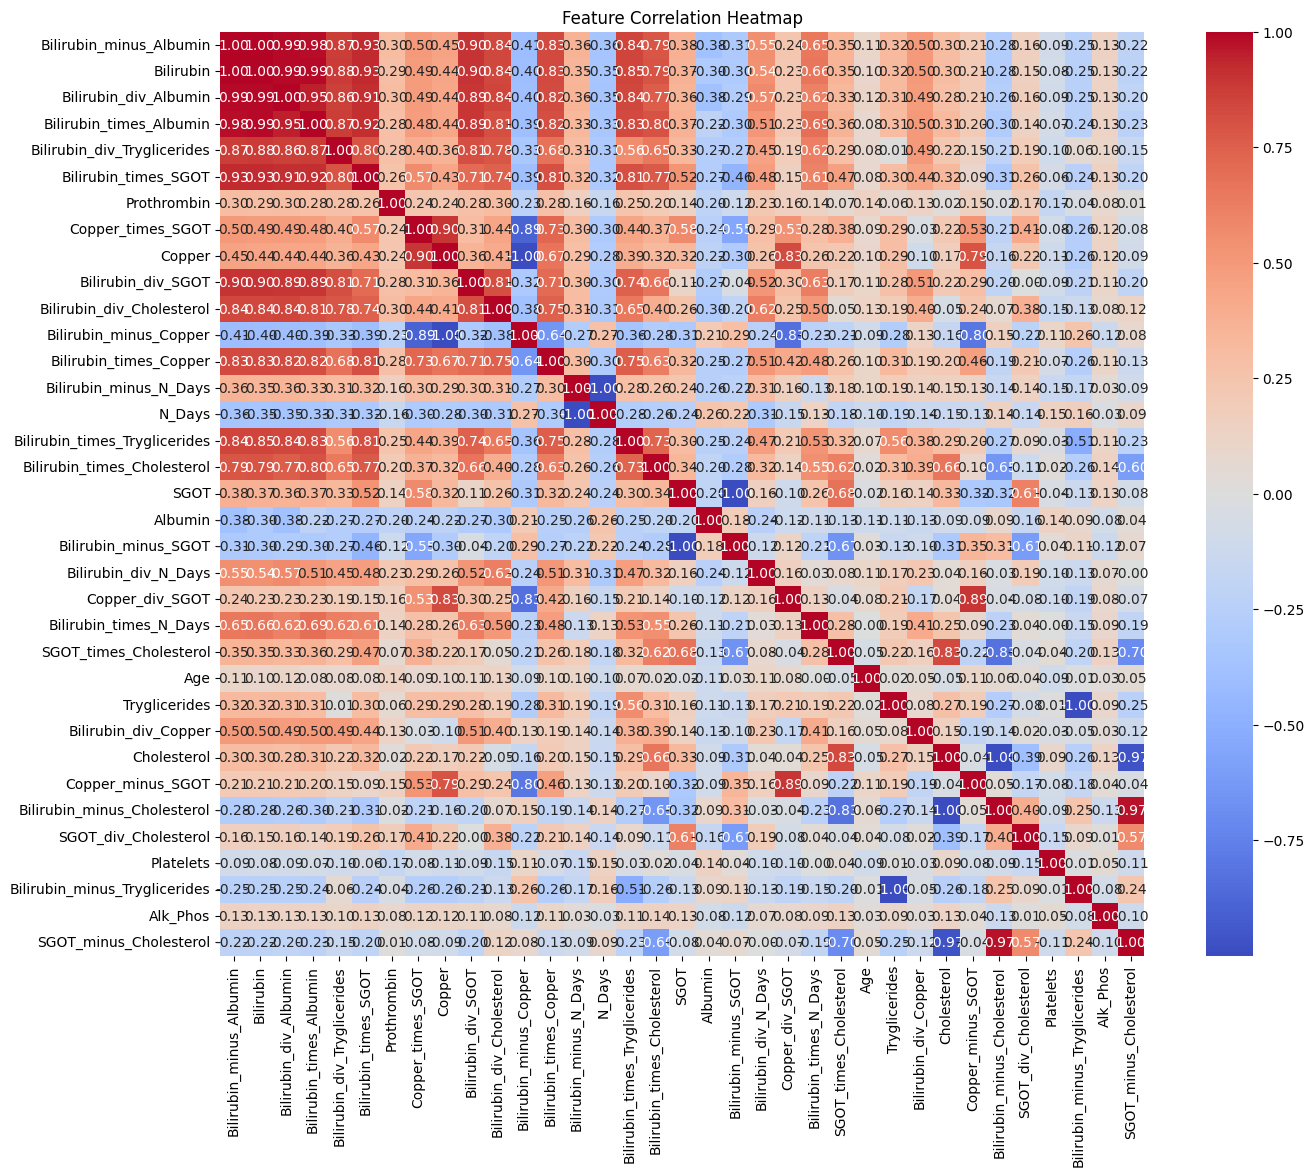

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Önemli feature isimlerini alalım
important_features = importance_df_new["Feature"].tolist()

# Sadece önemli feature'ları seçelim
corr_matrix = train_extend[important_features].corr()

# Korelasyon matrisini çizelim
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
def find_highly_correlated_features(corr_matrix, threshold=0.90):
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                to_drop.add(colname)
    return list(to_drop)

high_corr_features = find_highly_correlated_features(corr_matrix, threshold=0.90)
print(f"Çok yüksek korelasyonlu (|corr|>0.90) feature'lar: {high_corr_features}")


Çok yüksek korelasyonlu (|corr|>0.90) feature'lar: ['SGOT_minus_Cholesterol', 'N_Days', 'Bilirubin_div_Albumin', 'Bilirubin_times_Albumin', 'Bilirubin_minus_Copper', 'Bilirubin', 'Bilirubin_minus_SGOT', 'Bilirubin_minus_Tryglicerides', 'Bilirubin_minus_Cholesterol', 'Bilirubin_times_SGOT', 'Bilirubin_div_SGOT']


In [ ]:
train_df_final = train_extend.drop(columns=high_corr_features)


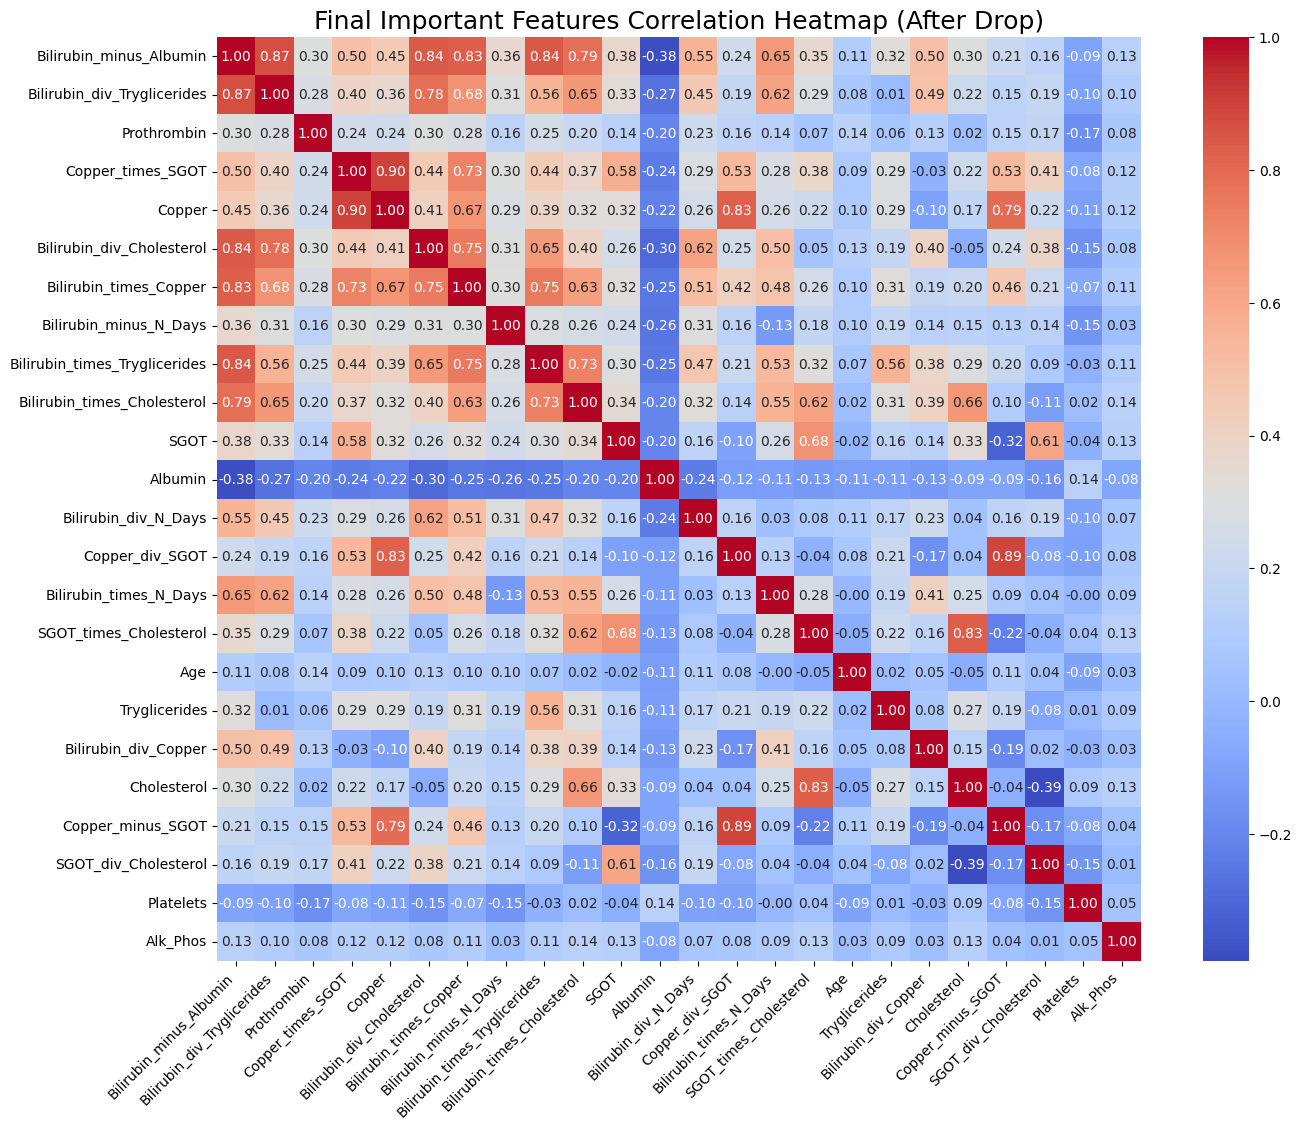

In [ ]:
# Yeni önemli feature'ları tekrar belirleyelim
important_features_final = [col for col in importance_df_new["Feature"].tolist() if col not in high_corr_features]

# Sadece kalan önemli feature'larla korelasyon matrisi
corr_matrix_final = train_df_final[important_features_final].corr()

# Yeni heatmap çizelim
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_final, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Final Important Features Correlation Heatmap (After Drop)", fontsize=18)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


In [ ]:
X_train = train_df_final.drop(columns=["Status"])
y_train = train_df_final["Status"]

X_test = test_df.copy()  # test_df içinde Status yok, sadece feature'lar var


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Modeli tanımla
model = RandomForestClassifier(random_state=42)

X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# (Model eğitimi ve submission için test seti de encode edilmeli!)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# CV ile model başarısını ölç
cv_accuracy = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring="accuracy")
cv_logloss = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring="neg_log_loss")

print("Mean CV Accuracy:", cv_accuracy.mean())
print("Mean CV LogLoss:", -cv_logloss.mean())


Mean CV Accuracy: 0.8192283364958886
Mean CV LogLoss: 0.5683586933701248


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

lgb_model = lgb.LGBMClassifier(random_state=42)

# Accuracy
cv_acc_lgb = cross_val_score(lgb_model, X_train_encoded, y_train, cv=5, scoring="accuracy")
print("LGBM Accuracy:", cv_acc_lgb.mean())

# LogLoss
cv_logloss_lgb = cross_val_score(lgb_model, X_train_encoded, y_train, cv=5, scoring="neg_log_loss")
print("LGBM LogLoss:", -cv_logloss_lgb.mean())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5671
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 33
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5667
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 33
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291
[LightGBM] [Info] Auto-choosing col-

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Accuracy
cv_acc_xgb = cross_val_score(xgb_model, X_train_encoded, y_train_encoded, cv=5, scoring="accuracy")
print("XGBoost Accuracy:", cv_acc_xgb.mean())

# LogLoss
cv_logloss_xgb = cross_val_score(xgb_model, X_train_encoded, y_train_encoded, cv=5, scoring="neg_log_loss")
print("XGBoost LogLoss:", -cv_logloss_xgb.mean())


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Accuracy: 0.8191018342820999


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost LogLoss: 0.5579420293847918


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# Model
cat_model = CatBoostClassifier(random_state=42, verbose=0)  # verbose=0 sessiz çalışsın

# Accuracy
cv_acc_cat = cross_val_score(cat_model, X_train_encoded, y_train_encoded, cv=5, scoring="accuracy")
print("CatBoost Accuracy:", cv_acc_cat.mean())

# LogLoss
cv_logloss_cat = cross_val_score(cat_model, X_train_encoded, y_train_encoded, cv=5, scoring="neg_log_loss")
print("CatBoost LogLoss:", -cv_logloss_cat.mean())


CatBoost Accuracy: 0.8208728652751424
CatBoost LogLoss: 0.4863322927032243


In [ ]:
X_train_raw = train_df.drop(columns=["Status"])
y_train_raw = train_df["Status"]

# One-hot encoding
X_train_raw_encoded = pd.get_dummies(X_train_raw, drop_first=True)

from sklearn.preprocessing import LabelEncoder

le_raw = LabelEncoder()
y_train_raw_encoded = le_raw.fit_transform(y_train_raw)

from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

cat_model_raw = CatBoostClassifier(random_state=42, verbose=0)

# Accuracy
cv_acc_cat_raw = cross_val_score(cat_model_raw, X_train_raw_encoded, y_train_raw_encoded, cv=5, scoring="accuracy")
print("Ham Veride CatBoost Accuracy:", cv_acc_cat_raw.mean())

# LogLoss
cv_logloss_cat_raw = cross_val_score(cat_model_raw, X_train_raw_encoded, y_train_raw_encoded, cv=5, scoring="neg_log_loss")
print("Ham Veride CatBoost LogLoss:", -cv_logloss_cat_raw.mean())


Ham Veride CatBoost Accuracy: 0.8199873497786212
Ham Veride CatBoost LogLoss: 0.4873048354058982


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1. CatBoost Modeli
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# 2. Parametre Dağılımları
param_dist = {
    "iterations": [300, 500, 700],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "bagging_temperature": [0.5, 1, 2]
}

# 3. Randomized Search CV
random_search = RandomizedSearchCV(
    cat_model,
    param_distributions=param_dist,
    n_iter=20,               # 20 farklı kombinasyon deneyecek
    scoring="neg_log_loss",  # Hedefimiz logloss'u minimize etmek
    cv=3,                    # 3-Fold Cross Validation
    verbose=2,               # Adım adım çıktıları görelim
    random_state=42,
    n_jobs=-1                # Tüm CPU'ları kullan
)

# 4. Eğitimi Başlatalım
random_search.fit(X_train_encoded, y_train_encoded)

# 5. En İyi Model ve Parametreler
best_cat_model = random_search.best_estimator_

print("🚀 En iyi parametreler:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
🚀 En iyi parametreler: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 8, 'bagging_temperature': 2}


In [ ]:
import numpy as np

# Bir kopya üzerinden çalışalım
train_df_extended_v2 = train_df.copy()

# Numerik değişkenler
num_cols = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Log dönüşümü (pozitif olanlar için)
for col in num_cols:
    train_df_extended_v2[f"log1p_{col}"] = np.log1p(train_df_extended_v2[col])

# Kareköklü dönüşüm
for col in num_cols:
    train_df_extended_v2[f"sqrt_{col}"] = np.sqrt(train_df_extended_v2[col])


In [ ]:
# Çarpım feature'ları
train_df_extended_v2["Bilirubin_times_Albumin"] = train_df_extended_v2["Bilirubin"] * train_df_extended_v2["Albumin"]
train_df_extended_v2["Copper_times_SGOT"] = train_df_extended_v2["Copper"] * train_df_extended_v2["SGOT"]
train_df_extended_v2["N_Days_times_Platelets"] = train_df_extended_v2["N_Days"] * train_df_extended_v2["Platelets"]


In [ ]:
X_train_v2 = train_df_extended_v2.drop(columns=["Status"])
y_train_v2 = train_df_extended_v2["Status"]

X_train_v2_encoded = pd.get_dummies(X_train_v2, drop_first=True)

# Label encode
le_v2 = LabelEncoder()
y_train_v2_encoded = le_v2.fit_transform(y_train_v2)

# CatBoost
cat_model_v2 = CatBoostClassifier(random_state=42, verbose=0)

cv_acc_cat_v2 = cross_val_score(cat_model_v2, X_train_v2_encoded, y_train_v2_encoded, cv=5, scoring="accuracy")
print("Yeni Featurelarla CatBoost Accuracy:", cv_acc_cat_v2.mean())

cv_logloss_cat_v2 = cross_val_score(cat_model_v2, X_train_v2_encoded, y_train_v2_encoded, cv=5, scoring="neg_log_loss")
print("Yeni Featurelarla CatBoost LogLoss:", -cv_logloss_cat_v2.mean())


Yeni Featurelarla CatBoost Accuracy: 0.8228969006957622
Yeni Featurelarla CatBoost LogLoss: 0.48177268338303864


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

lgb_model_v2 = lgb.LGBMClassifier(random_state=42)

cv_acc_lgb_v2 = cross_val_score(lgb_model_v2, X_train_v2_encoded, y_train_v2_encoded, cv=5, scoring="accuracy")
print("Yeni Featurelarla LGBM Accuracy:", cv_acc_lgb_v2.mean())

cv_logloss_lgb_v2 = cross_val_score(lgb_model_v2, X_train_v2_encoded, y_train_v2_encoded, cv=5, scoring="neg_log_loss")
print("Yeni Featurelarla LGBM LogLoss:", -cv_logloss_lgb_v2.mean())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6763
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 45
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6751
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 45
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 secon

In [ ]:
import xgboost as xgb

xgb_model_v2 = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

cv_acc_xgb_v2 = cross_val_score(xgb_model_v2, X_train_v2_encoded, y_train_v2_encoded, cv=5, scoring="accuracy")
print("Yeni Featurelarla XGBoost Accuracy:", cv_acc_xgb_v2.mean())

cv_logloss_xgb_v2 = cross_val_score(xgb_model_v2, X_train_v2_encoded, y_train_v2_encoded, cv=5, scoring="neg_log_loss")
print("Yeni Featurelarla XGBoost LogLoss:", -cv_logloss_xgb_v2.mean())


Yeni Featurelarla XGBoost Accuracy: 0.8211258697027197
Yeni Featurelarla XGBoost LogLoss: 0.5453978277808187


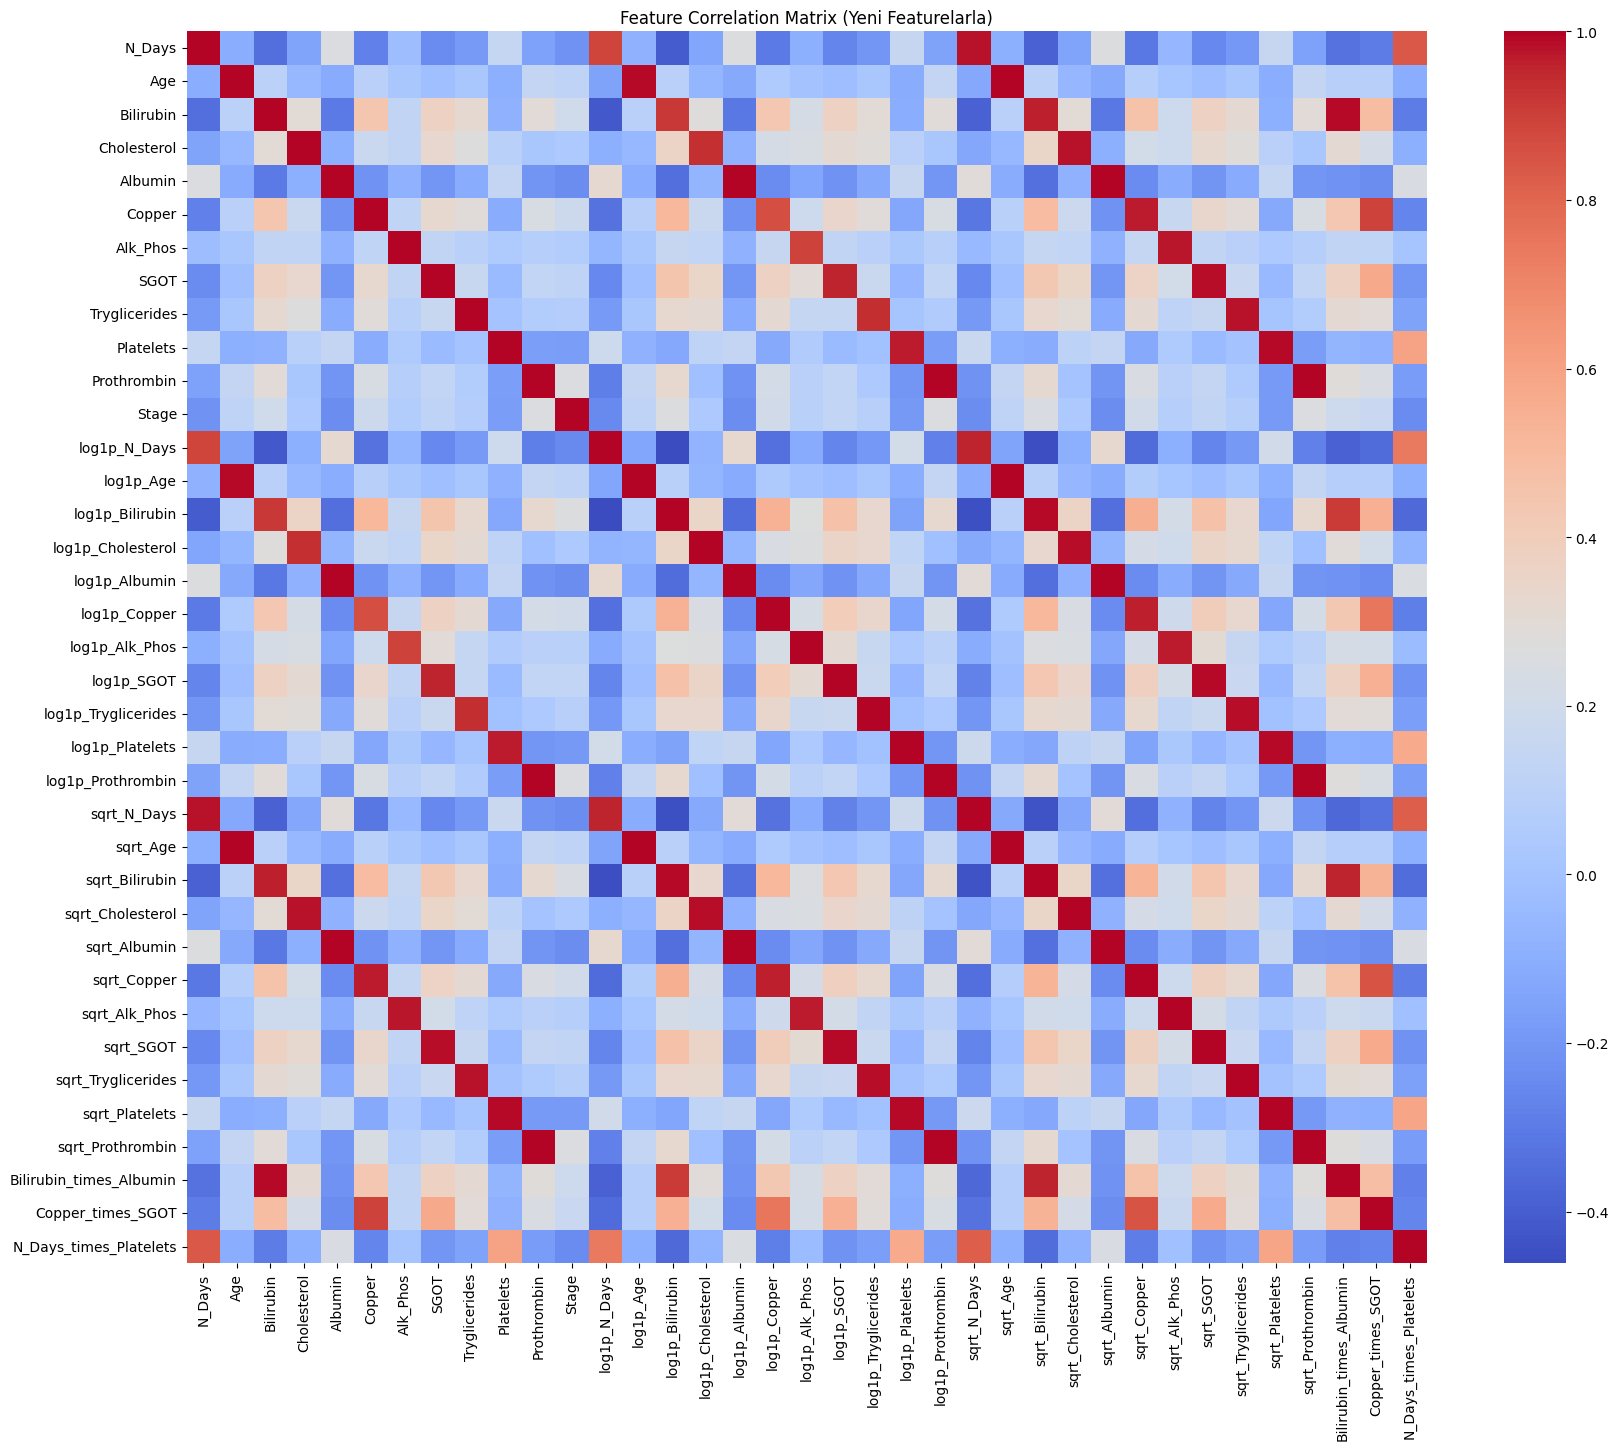

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Numerik feature'lar (id hariç)
numerical_features_v2 = [col for col in train_df_extended_v2.columns if train_df_extended_v2[col].dtype != "O" and col != "id"]

# Korelasyon matrisi
corr_matrix = train_df_extended_v2[numerical_features_v2].corr()

# Görselleştirme
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix (Yeni Featurelarla)")
plt.show()


In [ ]:
# Yeni featurelar
train_df_extended_v2["Bilirubin_minus_Albumin"] = train_df_extended_v2["Bilirubin"] - train_df_extended_v2["Albumin"]
train_df_extended_v2["Bilirubin_div_Albumin"] = train_df_extended_v2["Bilirubin"] / (train_df_extended_v2["Albumin"] + 1e-6)

train_df_extended_v2["Copper_minus_SGOT"] = train_df_extended_v2["Copper"] - train_df_extended_v2["SGOT"]
train_df_extended_v2["Copper_div_SGOT"] = train_df_extended_v2["Copper"] / (train_df_extended_v2["SGOT"] + 1e-6)

train_df_extended_v2["Cholesterol_minus_Tryglicerides"] = train_df_extended_v2["Cholesterol"] - train_df_extended_v2["Tryglicerides"]
train_df_extended_v2["Cholesterol_div_Tryglicerides"] = train_df_extended_v2["Cholesterol"] / (train_df_extended_v2["Tryglicerides"] + 1e-6)

train_df_extended_v2["SGOT_minus_Alk_Phos"] = train_df_extended_v2["SGOT"] - train_df_extended_v2["Alk_Phos"]
train_df_extended_v2["SGOT_div_Alk_Phos"] = train_df_extended_v2["SGOT"] / (train_df_extended_v2["Alk_Phos"] + 1e-6)


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# 1. Final eğitim seti
X_train_final = train_df_extended_v2.drop(columns=["Status"])
y_train_final = train_df_extended_v2["Status"]

# 2. Encode
X_train_final_encoded = pd.get_dummies(X_train_final, drop_first=True)
from sklearn.preprocessing import LabelEncoder
le_final = LabelEncoder()
y_train_final_encoded = le_final.fit_transform(y_train_final)

# 3. CatBoost modeli
cat_model_final = CatBoostClassifier(random_state=42, verbose=0)

# 4. Cross-validation Accuracy
cv_acc_cat_final = cross_val_score(cat_model_final, X_train_final_encoded, y_train_final_encoded, cv=5, scoring="accuracy")
print("Yeni Featurelarla CatBoost Accuracy:", cv_acc_cat_final.mean())

# 5. Cross-validation LogLoss
cv_logloss_cat_final = cross_val_score(cat_model_final, X_train_final_encoded, y_train_final_encoded, cv=5, scoring="neg_log_loss")
print("Yeni Featurelarla CatBoost LogLoss:", -cv_logloss_cat_final.mean())


Yeni Featurelarla CatBoost Accuracy: 0.8206198608475649
Yeni Featurelarla CatBoost LogLoss: 0.48246691783508033


In [ ]:
from sklearn.inspection import permutation_importance

# Permutation Importance hesaplama
perm_importance = permutation_importance(
    catboost_model,                  # Eğitilmiş model
    X_train_final_encoded,            # Feature set
    y_train_final_encoded,            # Hedef değişken
    scoring="accuracy",               # Başarı ölçütü
    n_repeats=10,                     # 10 kere shuffle tekrar yap
    random_state=42,
    n_jobs=-1                         # Bütün işlemcileri kullanarak hızlandır
)

# Sonuçları DataFrame haline getirme
perm_importance_df = pd.DataFrame({
    "Feature": X_train_final_encoded.columns,
    "Importance_Mean": perm_importance.importances_mean,
    "Importance_Std": perm_importance.importances_std
}).sort_values(by="Importance_Mean", ascending=False)

# İlk 30 feature'ı görelim
perm_importance_df.head(30)


,Feature,Importance_Mean,Importance_Std
36,N_Days_times_Platelets,0.019747,0.000745
9,Platelets,0.016964,0.000581
1,Age,0.016635,0.000840
0,N_Days,0.016610,0.001093
42,Cholesterol_div_Tryglicerides,0.016066,0.001168
44,SGOT_div_Alk_Phos,0.014510,0.000622
39,Copper_minus_SGOT,0.014358,0.000949
4,Albumin,0.014194,0.000722
37,Bilirubin_minus_Albumin,0.013713,0.001237
10,Prothrombin,0.013612,0.000810


In [ ]:
# 0.007'den büyük importance'a sahip feature'lar
important_perm_features = perm_importance_df[perm_importance_df["Importance_Mean"] > 0.007]["Feature"].tolist()

print(f"Seçilen feature sayısı: {len(important_perm_features)}")

# Yeni final X
X_train_final_perm = X_train_final_encoded[important_perm_features]

# Yeni CatBoost modeli
catboost_model_final_perm = CatBoostClassifier(random_state=42, verbose=0)

# CV Accuracy
cv_acc_final_perm = cross_val_score(catboost_model_final_perm, X_train_final_perm, y_train_final_encoded, cv=5, scoring="accuracy")
print("Permutation Featurelarla CatBoost Accuracy:", cv_acc_final_perm.mean())

# CV LogLoss
cv_logloss_final_perm = cross_val_score(catboost_model_final_perm, X_train_final_perm, y_train_final_encoded, cv=5, scoring="neg_log_loss")
print("Permutation Featurelarla CatBoost LogLoss:", -cv_logloss_final_perm.mean())


Seçilen feature sayısı: 24
Permutation Featurelarla CatBoost Accuracy: 0.8226438962681847
Permutation Featurelarla CatBoost LogLoss: 0.4748426110451659


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Random Forest modeli
rf_model = RandomForestClassifier(random_state=42)

# CV Accuracy
cv_acc_rf = cross_val_score(rf_model, X_train_final_perm, y_train_final_encoded, cv=5, scoring="accuracy")
print("Random Forest Accuracy (24 Feature):", cv_acc_rf.mean())

# CV LogLoss
cv_logloss_rf = cross_val_score(rf_model, X_train_final_perm, y_train_final_encoded, cv=5, scoring="neg_log_loss")
print("Random Forest LogLoss (24 Feature):", -cv_logloss_rf.mean())


Random Forest Accuracy (24 Feature): 0.8137887413029729
Random Forest LogLoss (24 Feature): 0.5661274062400812
